# Enforcement Prediction Model

This notebook predicts the likelihood of getting a parking ticket for unpaid parking.

**Prerequisites:** Run notebook 13 (`13_create_amp_zone_mapping.ipynb`) first to create `amp_zone_aliases.csv`.

## The Question

**"If I park without a permit in zone/lot X at time Y for Z hours, what's my ticket risk?"**

## Approach

For each (zone/lot, hour):
1. Count tickets issued
2. Count LPR scans (all vehicles detected)
3. Count AMP sessions (paid parkers)
4. Estimate unpaid vehicles: `LPR scans - AMP sessions`
5. Calculate enforcement rate: `tickets / unpaid vehicles`
6. Enrich with calendar events (game days, finals, breaks) and weather
7. Predict ticket risk based on zone, time, duration, and context

## Data Sources

- **LPR data** (1.8M reads): All vehicles detected by cameras
- **AMP data** (1.7M sessions): Paid parking sessions
- **Ticket data** (19M records): Enforcement actions
- **Calendar/Weather**: Contextual factors

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

In [18]:
# Load preprocessed data
amp = pd.read_csv('../data/processed/amp_preprocessed.csv', parse_dates=['Start_Date', 'End_Date'])
lpr = pd.read_csv('../data/processed/lpr_preprocessed.csv', parse_dates=['Date_Time'])
tickets = pd.read_csv('../data/processed/tickets_enriched.csv', parse_dates=['Issue_DateTime'])
lot_mapping = pd.read_csv('../data/lot_mapping_enhanced.csv')

print(f"AMP sessions: {len(amp):,}")
print(f"LPR reads: {len(lpr):,}")
print(f"Tickets issued: {len(tickets):,}")

print(f"\nDate ranges:")
print(f"  AMP: {amp['Start_Date'].min()} to {amp['End_Date'].max()}")
print(f"  LPR: {lpr['Date_Time'].min()} to {lpr['Date_Time'].max()}")
print(f"  Tickets: {tickets['Issue_DateTime'].min()} to {tickets['Issue_DateTime'].max()}")

AMP sessions: 1,702,867
LPR reads: 1,780,391
Tickets issued: 192,709

Date ranges:
  AMP: 2020-08-10 07:51:00 to 2025-11-02 12:38:00
  LPR: 2022-07-01 05:24:26 to 2025-06-30 21:58:49
  Tickets: 2018-07-02 08:13:00 to 2025-10-30 15:56:00


## Map AMP Zone Names to Lot Numbers

Apply AMP zone aliases (created in notebook 13) and use lot_mapping location descriptions as fallback.

In [19]:
# Load AMP zone aliases (created in notebook 13)
amp_aliases = pd.read_csv('../data/amp_zone_aliases.csv')
print(f"Loaded {len(amp_aliases)} AMP zone aliases")

# Step 1: Merge with AMP zone aliases
amp = amp.merge(
    amp_aliases[['AMP_Zone_Name', 'Lot_number', 'Standard_Zone_Name', 'zone_type']],
    left_on='Zone',
    right_on='AMP_Zone_Name',
    how='left'
)

print(f"After alias mapping: {amp['Lot_number'].notna().sum():,} / {len(amp):,} sessions mapped ({amp['Lot_number'].notna().sum()/len(amp)*100:.1f}%)")

# Step 2: For unmapped zones, try matching against lot_mapping location_description AND alternative_location_description
unmapped_mask = amp['Lot_number'].isna()
unmapped_zones = amp[unmapped_mask]['Zone'].unique()

if len(unmapped_zones) > 0:
    print(f"\nAttempting to map {len(unmapped_zones)} unmapped zone names using location descriptions...")
    
    for zone in unmapped_zones:
        zone_upper = str(zone).upper()
        matches = None
        
        # First, try to match against location_description (case-insensitive, partial match)
        matches = lot_mapping[lot_mapping['location_description'].str.upper().str.contains(zone_upper, na=False, regex=False)]
        
        # If no match, try alternative_location_description (supports '|' delimited multiple values)
        if len(matches) == 0 and 'alternative_location_description' in lot_mapping.columns:
            # Create a function to check if zone matches any alternative (split by '|')
            def check_alternatives(alt_desc):
                if pd.isna(alt_desc):
                    return False
                alternatives = str(alt_desc).split('|')
                return any(zone_upper in alt.strip().upper() for alt in alternatives)
            
            matches = lot_mapping[lot_mapping['alternative_location_description'].apply(check_alternatives)]
        
        if len(matches) == 1:
            # Exact single match found
            lot_num = matches.iloc[0]['Lot_number']
            std_zone = matches.iloc[0]['Zone_Name']
            z_type = matches.iloc[0]['zone_type']
            
            amp.loc[amp['Zone'] == zone, 'Lot_number'] = lot_num
            amp.loc[amp['Zone'] == zone, 'Standard_Zone_Name'] = std_zone
            amp.loc[amp['Zone'] == zone, 'zone_type'] = z_type
            print(f"  ✓ Matched '{zone}' → Lot {lot_num} ({std_zone})")
        elif len(matches) > 1:
            print(f"  ⚠ Multiple matches for '{zone}' - skipping (needs manual mapping)")

# Step 3: Try zone prefix extraction for remaining unmapped zones
unmapped_mask = amp['Lot_number'].isna()
if unmapped_mask.sum() > 0:
    print(f"\nAttempting zone prefix extraction for {unmapped_mask.sum():,} remaining unmapped sessions...")
    
    def extract_zone_prefix(zone_name):
        if pd.isna(zone_name):
            return None
        zone_upper = str(zone_name).upper()
        colors = ['GREEN', 'RED', 'YELLOW', 'BLUE', 'ORANGE', 'CRIMSON', 'GRAY', 'GREY']
        for color in colors:
            if zone_upper.startswith(color):
                parts = zone_name.split()
                if len(parts) >= 2 and parts[1].replace(':', '').isdigit():
                    return f"{parts[0]} {parts[1].replace(':', '')}"
        return zone_name
    
    amp.loc[unmapped_mask, 'Zone_Prefix'] = amp.loc[unmapped_mask, 'Zone'].apply(extract_zone_prefix)
    
    for idx, row in amp[unmapped_mask].iterrows():
        prefix_upper = str(row['Zone_Prefix']).upper() if pd.notna(row.get('Zone_Prefix')) else None
        if prefix_upper:
            match = lot_mapping[lot_mapping['Zone_Name'].str.upper() == prefix_upper]
            if len(match) > 0:
                amp.at[idx, 'Lot_number'] = match.iloc[0]['Lot_number']
                amp.at[idx, 'Standard_Zone_Name'] = match.iloc[0]['Zone_Name']
                amp.at[idx, 'zone_type'] = match.iloc[0]['zone_type']

# Final summary
print(f"\n{'='*80}")
print("FINAL AMP ZONE MAPPING RESULTS")
print('='*80)
print(f"Sessions with lot numbers: {amp['Lot_number'].notna().sum():,} / {len(amp):,} ({amp['Lot_number'].notna().sum()/len(amp)*100:.1f}%)")
print(f"Sessions still unmapped: {amp['Lot_number'].isna().sum():,} ({amp['Lot_number'].isna().sum()/len(amp)*100:.1f}%)")

# Show unmapped zones that need manual mapping
unmapped_zones_final = amp[amp['Lot_number'].isna()]['Zone'].value_counts()
if len(unmapped_zones_final) > 0:
    print(f"\n{'='*80}")
    print("UNMAPPED ZONES REQUIRING MANUAL MAPPING")
    print('='*80)
    print("Add these to notebook 13 (amp_zone_aliases dictionary) or to lot_mapping_enhanced.csv:")
    print()
    for zone, count in unmapped_zones_final.items():
        print(f"  '{zone}': (XXX, 'Zone Name'),  # {count:,} sessions")
    print(f"\nTotal unmapped sessions: {unmapped_zones_final.sum():,}")
else:
    print("\n All AMP zones successfully mapped!")

print(f"\nTop 10 AMP zones (by session count):")
for zone, count in amp['Zone'].value_counts().head(10).items():
    if len(amp[amp['Zone'] == zone]) > 0:
        lot = amp[amp['Zone'] == zone].iloc[0]['Lot_number']
        std_zone = amp[amp['Zone'] == zone].iloc[0]['Standard_Zone_Name']
        status = '✓' if pd.notna(lot) else '✗'
        print(f"  {status} {zone:50} → Lot {lot} ({std_zone})  [{count:,} sessions]")

Loaded 59 AMP zone aliases
After alias mapping: 1,698,169 / 1,702,867 sessions mapped (99.7%)

Attempting to map 4 unmapped zone names using location descriptions...

Attempting zone prefix extraction for 4,698 remaining unmapped sessions...
After alias mapping: 1,698,169 / 1,702,867 sessions mapped (99.7%)

Attempting to map 4 unmapped zone names using location descriptions...

Attempting zone prefix extraction for 4,698 remaining unmapped sessions...

FINAL AMP ZONE MAPPING RESULTS
Sessions with lot numbers: 1,698,169 / 1,702,867 (99.7%)
Sessions still unmapped: 4,698 (0.3%)

UNMAPPED ZONES REQUIRING MANUAL MAPPING
Add these to notebook 13 (amp_zone_aliases dictionary) or to lot_mapping_enhanced.csv:

  'Don't Activate: Lighty East Meters': (XXX, 'Zone Name'),  # 4,099 sessions
  'PACCAR: (Don't Activate)': (XXX, 'Zone Name'),  # 568 sessions
  'Testing Zone with an extra long label to read (Don't activate)': (XXX, 'Zone Name'),  # 22 sessions
  'Disability Parking CUE (Don't Activat

## Create Hourly Time Grid

Generate all (date, hour) combinations for the overlapping period across all datasets.

In [20]:
# Find overlapping date range
start_date = max(amp['Start_Date'].min(), lpr['Date_Time'].min(), tickets['Issue_DateTime'].min()).date()
end_date = min(amp['End_Date'].max(), lpr['Date_Time'].max(), tickets['Issue_DateTime'].max()).date()

print(f"Using overlapping date range: {start_date} to {end_date}")

# Create date range
date_range = pd.date_range(start=start_date, end=end_date, freq='D')
hours = range(24)

# Create time grid
time_grid = pd.MultiIndex.from_product(
    [date_range, hours],
    names=['date', 'hour']
).to_frame(index=False)

time_grid['datetime'] = pd.to_datetime(time_grid['date']) + pd.to_timedelta(time_grid['hour'], unit='h')

print(f"\nTime grid: {len(time_grid):,} hourly intervals")

Using overlapping date range: 2022-07-01 to 2025-06-30

Time grid: 26,304 hourly intervals


## Calculate Hourly Enforcement Metrics

For each zone and hour:
- Count LPR scans (all vehicles)
- Count AMP sessions (paid parking)
- Count tickets issued
- Estimate enforcement rate

In [21]:
# Get unique zones from tickets (these are the general zone categories)
# Tickets use simple names like "Green 5", while AMP/LPR have specific lot names like "Green 5 South Beasley"
ticket_zones = tickets['Zone_Name'].dropna().unique()

print(f"Processing enforcement data for {len(ticket_zones)} ticket zones...")
print("This will take 5-10 minutes...")

enforcement_list = []

for zone in ticket_zones:
    print(f"Processing zone: {zone}")
    
    # Filter data for this zone
    # For AMP and LPR, match any lot that contains this zone name
    zone_amp = amp[amp['Zone'].str.contains(zone, case=False, na=False)].copy()
    zone_lpr = lpr[lpr['Zone_Name'].str.contains(zone, case=False, na=False)].copy()
    zone_tickets = tickets[tickets['Zone_Name'] == zone].copy()
    
    # Process each hour in time grid
    for _, row in time_grid.iterrows():
        hour_start = row['datetime']
        hour_end = hour_start + pd.Timedelta(hours=1)
        
        # Count AMP sessions active during this hour
        amp_active = zone_amp[
            (zone_amp['Start_Date'] < hour_end) & 
            (zone_amp['End_Date'] > hour_start)
        ]
        amp_count = len(amp_active)
        
        # Count LPR scans during this hour
        lpr_in_hour = zone_lpr[
            (zone_lpr['Date_Time'] >= hour_start) & 
            (zone_lpr['Date_Time'] < hour_end)
        ]
        lpr_count = len(lpr_in_hour)
        
        # Count tickets issued during this hour
        tickets_in_hour = zone_tickets[
            (zone_tickets['Issue_DateTime'] >= hour_start) & 
            (zone_tickets['Issue_DateTime'] < hour_end)
        ]
        ticket_count = len(tickets_in_hour)
        
        # Estimate unpaid vehicles (LPR scans - AMP sessions)
        # Note: This is a rough approximation as LPR captures snapshots, AMP captures sessions
        unpaid_estimate = max(0, lpr_count - amp_count)
        
        # Calculate enforcement rate (avoid division by zero)
        if unpaid_estimate > 0:
            enforcement_rate = ticket_count / unpaid_estimate
        else:
            enforcement_rate = 0
        
        enforcement_list.append({
            'Zone': zone,
            'date': row['date'],
            'hour': row['hour'],
            'datetime': hour_start,
            'lpr_scans': lpr_count,
            'amp_sessions': amp_count,
            'tickets_issued': ticket_count,
            'unpaid_estimate': unpaid_estimate,
            'enforcement_rate': enforcement_rate
        })

# Convert to DataFrame
enforcement_df = pd.DataFrame(enforcement_list)

print(f"\nEnforcement data created: {len(enforcement_df):,} zone-hour records")
print(f"Date range: {enforcement_df['date'].min()} to {enforcement_df['date'].max()}")

Processing enforcement data for 25 ticket zones...
This will take 5-10 minutes...
Processing zone: Orange 4
Processing zone: Orange 4
Processing zone: Red 5
Processing zone: Green 3
Processing zone: Yellow 1
Processing zone: Yellow 4
Processing zone: Green 4
Processing zone: Green 5
Processing zone: Paid
Processing zone: Red 1
Processing zone: Green 1
Processing zone: Yellow 2
Processing zone: Crimson 2
Processing zone: Blue 1
Processing zone: Authorized Vehicles Only
Processing zone: Yellow5
Processing zone: Disability
Processing zone: Green 2
Processing zone: Red 4
Processing zone: Gray 1
Processing zone: Apartments
Processing zone: Grey 2
Processing zone: Yellow 3
Processing zone: Buisness Parking
Processing zone: Yellow 5
Processing zone: Visitor

Enforcement data created: 657,600 zone-hour records
Date range: 2022-07-01 00:00:00 to 2025-06-30 00:00:00


## Add Temporal Features

In [22]:
# Extract temporal features
enforcement_df['year'] = enforcement_df['datetime'].dt.year
enforcement_df['month'] = enforcement_df['datetime'].dt.month
enforcement_df['day'] = enforcement_df['datetime'].dt.day
enforcement_df['day_of_week'] = enforcement_df['datetime'].dt.dayofweek
enforcement_df['day_name'] = enforcement_df['datetime'].dt.day_name()
enforcement_df['is_weekend'] = (enforcement_df['day_of_week'] >= 5).astype(int)

# Time of day categories
def categorize_time_of_day(hour):
    if 0 <= hour < 6:
        return 'Late Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 22:
        return 'Evening'
    else:
        return 'Night'

enforcement_df['time_of_day'] = enforcement_df['hour'].apply(categorize_time_of_day)

print("Temporal features added")

Temporal features added


## Merge Calendar Events

Add game days, finals weeks, and breaks - these strongly influence enforcement patterns.

In [23]:
# Load calendar data
games = pd.read_csv('../data/football_games.csv')
calendar = pd.read_csv('../data/academic_calendar.csv')

# Parse dates
games['Date'] = pd.to_datetime(games['Date'])
calendar['Start_Date'] = pd.to_datetime(calendar['Start_Date'])
calendar['End_Date'] = pd.to_datetime(calendar['End_Date'])

# Convert enforcement_df['date'] to datetime
enforcement_df['date'] = pd.to_datetime(enforcement_df['date'])

# Mark game days
game_dates = games['Date'].dt.date.unique()
enforcement_df['is_game_day'] = enforcement_df['date'].dt.date.isin(game_dates).astype(int)

# Mark calendar events
for event_type in ['Finals_Week', 'Spring_Break', 'Thanksgiving_Break', 'Winter_Break', 'University_Holiday']:
    event_periods = calendar[calendar['Event_Type'] == event_type]
    
    enforcement_df[f'is_{event_type.lower()}'] = 0
    
    for _, period in event_periods.iterrows():
        mask = (enforcement_df['date'] >= period['Start_Date']) & \
               (enforcement_df['date'] <= period['End_Date'])
        enforcement_df.loc[mask, f'is_{event_type.lower()}'] = 1

# Create combined break indicator
enforcement_df['is_any_break'] = (
    enforcement_df['is_spring_break'] | 
    enforcement_df['is_thanksgiving_break'] | 
    enforcement_df['is_winter_break']
).astype(int)

print("Calendar events merged")
print(f"\nGame day hours: {enforcement_df['is_game_day'].sum():,}")
print(f"Finals week hours: {enforcement_df['is_finals_week'].sum():,}")
print(f"Break hours: {enforcement_df['is_any_break'].sum():,}")

Calendar events merged

Game day hours: 11,400
Finals week hours: 18,000
Break hours: 70,800


## Merge Weather Data

In [24]:
# Load weather data
weather = pd.read_csv('../data/weather_pullman_hourly_2020_2025.csv', parse_dates=['datetime'])
weather['date'] = pd.to_datetime(weather['date']).dt.date
weather['hour'] = weather['hour'].astype(int)

# Convert enforcement_df['date'] to date object for merging
enforcement_df['date_for_merge'] = enforcement_df['date'].dt.date

# Merge weather on both date AND hour for accurate hourly matching
enforcement_df = enforcement_df.merge(
    weather, 
    left_on=['date_for_merge', 'hour'], 
    right_on=['date', 'hour'], 
    how='left'
)

# Drop the temporary merge column and redundant date column from weather
enforcement_df = enforcement_df.drop(columns=['date_for_merge', 'date_y', 'datetime_y'], errors='ignore')
enforcement_df = enforcement_df.rename(columns={'date_x': 'date', 'datetime_x': 'datetime'})

print("Hourly weather data merged")
print(f"\nWeather columns added: {[col for col in weather.columns if col not in ['date', 'hour', 'datetime', 'year']]}")

Hourly weather data merged

Weather columns added: ['temperature_f', 'precipitation_inches', 'snowfall_inches', 'snow_depth_inches', 'wind_mph', 'weather_code', 'weather_category', 'is_rainy', 'is_snowy', 'is_cold', 'is_hot', 'is_windy', 'is_severe']


## Merge Fixed Camera Classification

Add fixed camera detection results to distinguish between:
- **Fixed cameras** (lots 71, 150): Automated 24/7 entrance scanning
- **Mobile patrols**: Walking/vehicle officers with scheduled visits

In [25]:
# Load fixed camera classification (created in notebook 16)
camera_data = pd.read_csv('../data/processed/fixed_camera_classification.csv')

# Keep only essential columns for merging
camera_features = camera_data[['Lot_number', 'camera_classification_v2', 'entrance_camera_score', 
                                 'bulk_patrol_score', 'avg_scans_per_active_hour']].copy()

# Create binary flag for fixed cameras
camera_features['has_fixed_camera'] = (camera_features['camera_classification_v2'] == 'FIXED_CAMERA_HIGH').astype(int)

# Convert Lot_number to string for merging (enforcement_df Zone is string)
camera_features['Lot_number'] = camera_features['Lot_number'].astype(str)

print(f"Loaded camera classification for {len(camera_features)} lots")
print(f"Fixed camera lots: {camera_features['has_fixed_camera'].sum()}")

# Check data types before merge
print(f"\nData types before merge:")
print(f"  enforcement_df['Zone']: {enforcement_df['Zone'].dtype}")
print(f"  camera_features['Lot_number']: {camera_features['Lot_number'].dtype}")

# Merge with enforcement data
# Note: enforcement_df uses 'Zone' which maps to lot numbers for some zones
# We need to extract lot numbers from Zone where possible

# For zones that are actually lot numbers (many AMP zones map to specific lots)
# This merge will work for lot-specific zones
enforcement_df = enforcement_df.merge(
    camera_features,
    left_on='Zone',  # Some zones are actually lot numbers or lot names
    right_on='Lot_number',
    how='left'
)

# Fill missing values (zones without cameras or non-lot zones)
enforcement_df['has_fixed_camera'] = enforcement_df['has_fixed_camera'].fillna(0).astype(int)
enforcement_df['entrance_camera_score'] = enforcement_df['entrance_camera_score'].fillna(0)
enforcement_df['bulk_patrol_score'] = enforcement_df['bulk_patrol_score'].fillna(100)  # Default to patrol
enforcement_df['avg_scans_per_active_hour'] = enforcement_df['avg_scans_per_active_hour'].fillna(0)

# Drop redundant columns
enforcement_df = enforcement_df.drop(columns=['Lot_number', 'camera_classification_v2'], errors='ignore')

print("\nFixed camera features merged")
print(f"Zone-hours with fixed cameras: {enforcement_df['has_fixed_camera'].sum():,}")
print(f"Zones with fixed cameras: {enforcement_df[enforcement_df['has_fixed_camera']==1]['Zone'].nunique()}")

# Show which zones have cameras
camera_zones = enforcement_df[enforcement_df['has_fixed_camera']==1]['Zone'].unique()
if len(camera_zones) > 0:
    print(f"\nZones with fixed cameras: {sorted(camera_zones)}")

Loaded camera classification for 185 lots
Fixed camera lots: 2

Data types before merge:
  enforcement_df['Zone']: object
  camera_features['Lot_number']: object

Fixed camera features merged
Zone-hours with fixed cameras: 0
Zones with fixed cameras: 0


## Exploratory Analysis of Enforcement Patterns

## Visualize Enforcement Patterns

In [26]:
# Summary statistics
print("="*70)
print("ENFORCEMENT SUMMARY STATISTICS")
print("="*70)

print(f"\nTotal zone-hour observations: {len(enforcement_df):,}")

print(f"\nTickets issued:")
print(enforcement_df['tickets_issued'].describe())

print(f"\nEnforcement rate (tickets per unpaid vehicle):")
print(enforcement_df[enforcement_df['enforcement_rate'] > 0]['enforcement_rate'].describe())

# Hours with enforcement activity
hours_with_tickets = (enforcement_df['tickets_issued'] > 0).sum()
print(f"\nHours with enforcement activity: {hours_with_tickets:,} ({hours_with_tickets/len(enforcement_df)*100:.1f}%)")

print(f"\n\nTop zones by ticket count:")
zone_tickets = enforcement_df.groupby('Zone')['tickets_issued'].sum().sort_values(ascending=False)
print(zone_tickets.head(15))

print(f"\n\nPeak enforcement hours:")
hour_tickets = enforcement_df.groupby('hour')['tickets_issued'].sum().sort_values(ascending=False)
print(hour_tickets.head(10))

ENFORCEMENT SUMMARY STATISTICS

Total zone-hour observations: 657,600

Tickets issued:
count    657600.000000
mean          0.071201
std           0.726353
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max          55.000000
Name: tickets_issued, dtype: float64

Enforcement rate (tickets per unpaid vehicle):
count    10248.000000
mean         0.180140
std          0.488561
min          0.001479
25%          0.027027
50%          0.074074
75%          0.179487
max         23.000000
Name: enforcement_rate, dtype: float64

Hours with enforcement activity: 12,877 (2.0%)


Top zones by ticket count:
Zone
Paid          25334
Green 5        5285
Green 3        2152
Yellow 4       1930
Apartments     1751
Green 4        1615
Crimson 2      1231
Grey 2         1110
Green 1         978
Orange 4        943
Red 4           836
Yellow 1        789
Yellow 2        623
Red 1           554
Gray 1          435
Name: tickets_issued, dtype: int64


Peak enfor

## Filter for Zones with Sufficient Data

Focus on zones with meaningful enforcement activity for reliable predictions.

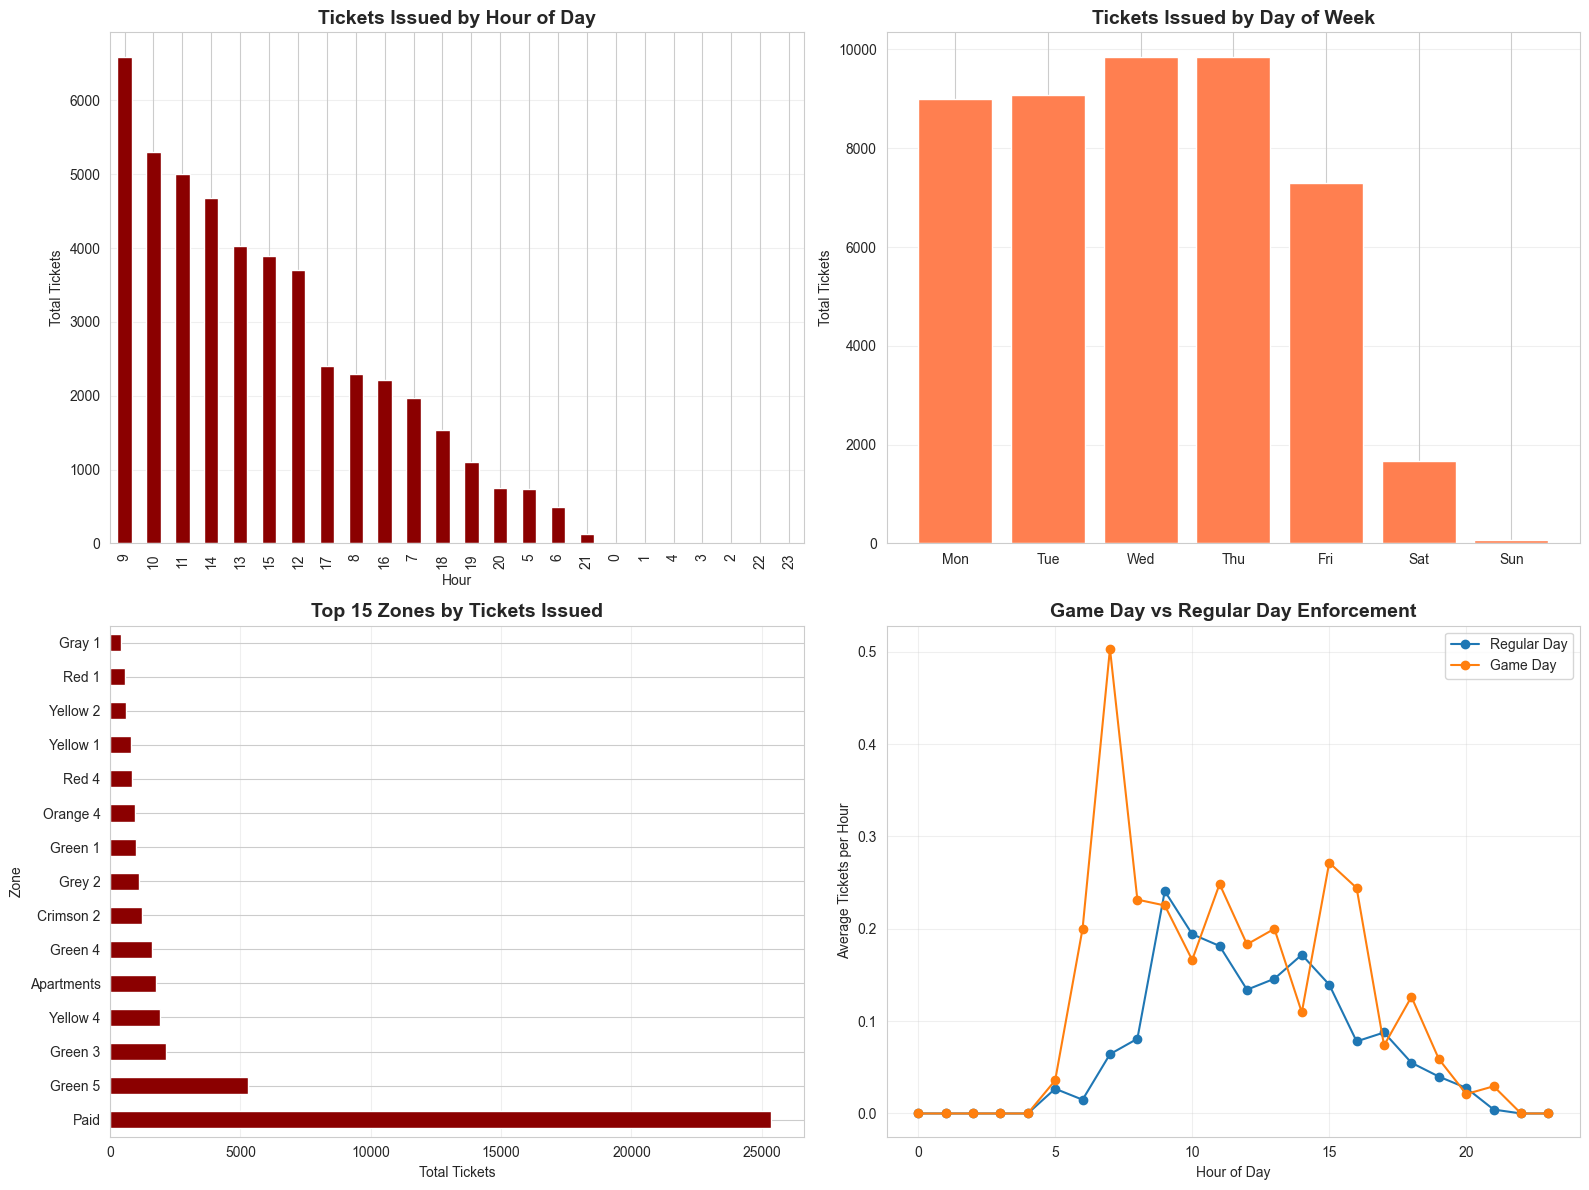

Enforcement patterns visualization saved


In [27]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Tickets by hour
hour_tickets.plot(kind='bar', ax=axes[0,0], color='darkred')
axes[0,0].set_title('Tickets Issued by Hour of Day', fontsize=14, fontweight='bold')
axes[0,0].set_xlabel('Hour')
axes[0,0].set_ylabel('Total Tickets')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Tickets by day of week
day_tickets = enforcement_df.groupby('day_of_week')['tickets_issued'].sum()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), day_tickets, color='coral')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names)
axes[0,1].set_title('Tickets Issued by Day of Week', fontsize=14, fontweight='bold')
axes[0,1].set_ylabel('Total Tickets')
axes[0,1].grid(axis='y', alpha=0.3)

# 3. Top zones by tickets
zone_tickets.head(15).plot(kind='barh', ax=axes[1,0], color='darkred')
axes[1,0].set_title('Top 15 Zones by Tickets Issued', fontsize=14, fontweight='bold')
axes[1,0].set_xlabel('Total Tickets')
axes[1,0].grid(axis='x', alpha=0.3)

# 4. Game day vs regular day enforcement
game_comparison = enforcement_df.groupby(['is_game_day', 'hour'])['tickets_issued'].mean().unstack(0)
if 1 in game_comparison.columns and 0 in game_comparison.columns:
    game_comparison.plot(ax=axes[1,1], marker='o')
    axes[1,1].set_title('Game Day vs Regular Day Enforcement', fontsize=14, fontweight='bold')
    axes[1,1].set_xlabel('Hour of Day')
    axes[1,1].set_ylabel('Average Tickets per Hour')
    axes[1,1].legend(['Regular Day', 'Game Day'])
    axes[1,1].grid(alpha=0.3)
else:
    axes[1,1].text(0.5, 0.5, 'Insufficient game day data', ha='center', va='center')
    axes[1,1].set_title('Game Day vs Regular Day Enforcement', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../data/processed/enforcement_patterns.png', dpi=300, bbox_inches='tight')
plt.show()

print("Enforcement patterns visualization saved")

In [28]:
# Identify zones with at least 100 tickets over the period
min_tickets = 100
zones_with_data = zone_tickets[zone_tickets >= min_tickets].index.tolist()

print(f"Zones with >={min_tickets} tickets: {len(zones_with_data)}")
print(f"These zones account for {zone_tickets[zones_with_data].sum()/zone_tickets.sum()*100:.1f}% of all tickets")

# Filter enforcement data
enforcement_filtered = enforcement_df[enforcement_df['Zone'].isin(zones_with_data)].copy()

print(f"\nFiltered dataset: {len(enforcement_filtered):,} records ({len(enforcement_filtered)/len(enforcement_df)*100:.1f}% of total)")

# Analyze fixed camera vs mobile patrol differences
print("\n" + "="*80)
print("FIXED CAMERA VS MOBILE PATROL COMPARISON")
print("="*80)

camera_stats = enforcement_df.groupby('has_fixed_camera').agg({
    'tickets_issued': ['sum', 'mean'],
    'lpr_scans': 'mean',
    'enforcement_rate': 'mean',
    'avg_scans_per_active_hour': 'mean'
}).round(3)

print("\nEnforcement Statistics by Type:")
print(camera_stats)

# Show enforcement patterns
print("\nFixed camera zones have:")
camera_zones_df = enforcement_df[enforcement_df['has_fixed_camera'] == 1]
patrol_zones_df = enforcement_df[enforcement_df['has_fixed_camera'] == 0]

if len(camera_zones_df) > 0:
    print(f"  - {camera_zones_df['tickets_issued'].sum():,} total tickets ({camera_zones_df['tickets_issued'].sum()/enforcement_df['tickets_issued'].sum()*100:.1f}% of all)")
    print(f"  - Average {camera_zones_df['lpr_scans'].mean():.1f} LPR scans per hour")
    print(f"  - Average {camera_zones_df['avg_scans_per_active_hour'].mean():.1f} scans per active hour (sporadic pattern)")
    
print(f"\nMobile patrol zones have:")
print(f"  - {patrol_zones_df['tickets_issued'].sum():,} total tickets ({patrol_zones_df['tickets_issued'].sum()/enforcement_df['tickets_issued'].sum()*100:.1f}% of all)")
print(f"  - Average {patrol_zones_df['lpr_scans'].mean():.1f} LPR scans per hour")
if patrol_zones_df['avg_scans_per_active_hour'].mean() > 0:
    print(f"  - Average {patrol_zones_df['avg_scans_per_active_hour'].mean():.1f} scans per active hour (bulk pattern)")


Zones with >=100 tickets: 19
These zones account for 99.6% of all tickets

Filtered dataset: 499,776 records (76.0% of total)

FIXED CAMERA VS MOBILE PATROL COMPARISON

Enforcement Statistics by Type:
                 tickets_issued        lpr_scans enforcement_rate  \
                            sum   mean      mean             mean   
has_fixed_camera                                                    
0                         46822  0.071     2.513            0.003   

                 avg_scans_per_active_hour  
                                      mean  
has_fixed_camera                            
0                                      0.0  

Fixed camera zones have:

Mobile patrol zones have:
  - 46,822 total tickets (100.0% of all)
  - Average 2.5 LPR scans per hour

Mobile patrol zones have:
  - 46,822 total tickets (100.0% of all)
  - Average 2.5 LPR scans per hour


## Weather vs AMP Parking Analysis

Let's check if weather actually impacts parking behavior (a "humor me" sanity check).

WEATHER IMPACT ON PARKING DEMAND

Parking demand by weather condition:
                  avg_sessions  median_sessions  total_sessions  observations
weather_category                                                             
Drizzle                   1.98              0.0          102326         51650
Rain                      1.78              0.0            7460          4200
Cloudy                    1.60              0.0          536271        335650
Snow                      1.56              0.0           43276         27800
Clear                     1.28              0.0          306172        238300

TEMPERATURE IMPACT ON PARKING

Parking metrics by temperature:
                     amp_sessions        lpr_scans       
                             mean median      mean median
temp_bin                                                 
<20°F (Extreme Cold)         1.19    0.0      2.27    0.0
20-40°F (Cold)               1.14    0.0      2.19    0.0
40-60°F (Moderate)           

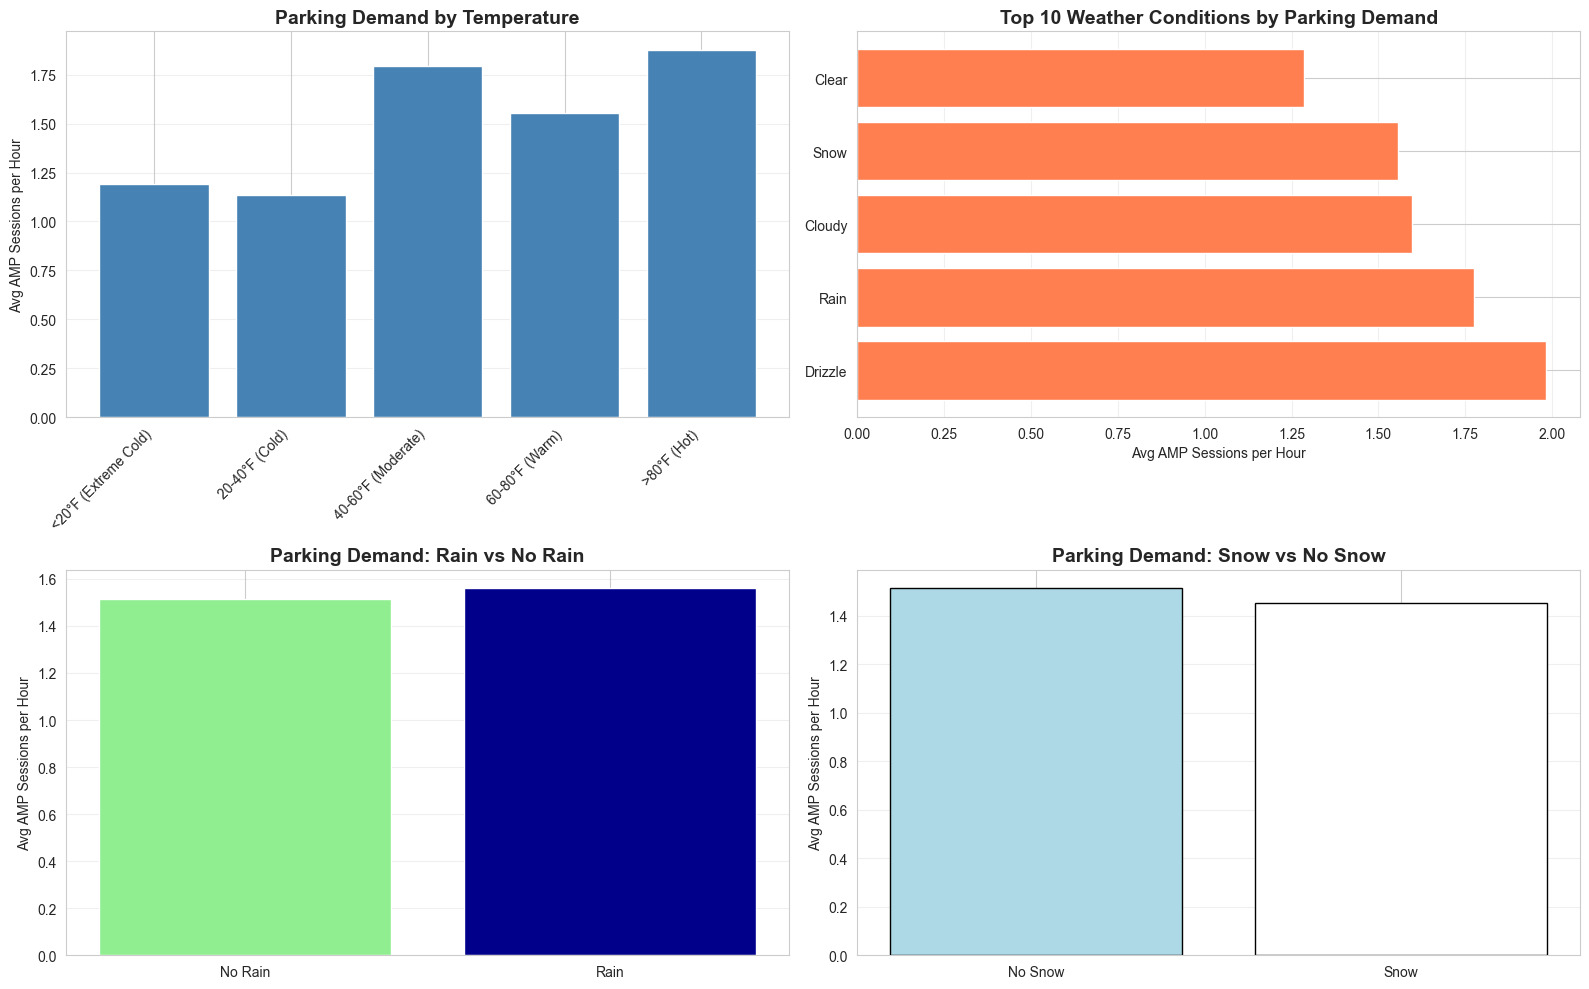


 Weather vs parking analysis complete - visualization saved

KEY INSIGHTS
Baseline parking demand (all conditions): 1.51 sessions/hour
Rainy days: 1.56 sessions/hour (+3.2% vs baseline)
Snowy days: 1.45 sessions/hour (-4.0% vs baseline)
Cold days (<32°F): 0.91 sessions/hour (-39.8% vs baseline)
Warm days (60°F+): 1.61 sessions/hour (+6.5% vs baseline)


In [29]:
# Analyze weather impact on parking demand (AMP sessions)
print("="*80)
print("WEATHER IMPACT ON PARKING DEMAND")
print("="*80)

# Group by weather conditions and calculate average AMP sessions
weather_impact = enforcement_df.groupby('weather_category').agg({
    'amp_sessions': ['mean', 'median', 'sum', 'count']
}).round(2)

weather_impact.columns = ['avg_sessions', 'median_sessions', 'total_sessions', 'observations']
weather_impact = weather_impact.sort_values('avg_sessions', ascending=False)

print("\nParking demand by weather condition:")
print(weather_impact.head(15))

# Temperature impact
print("\n" + "="*80)
print("TEMPERATURE IMPACT ON PARKING")
print("="*80)

# Create temperature bins
enforcement_df['temp_bin'] = pd.cut(enforcement_df['temperature_f'], 
                                      bins=[-20, 20, 40, 60, 80, 120],
                                      labels=['<20°F (Extreme Cold)', '20-40°F (Cold)', 
                                             '40-60°F (Moderate)', '60-80°F (Warm)', '>80°F (Hot)'])

temp_impact = enforcement_df.groupby('temp_bin', observed=True).agg({
    'amp_sessions': ['mean', 'median'],
    'lpr_scans': ['mean', 'median']
}).round(2)

print("\nParking metrics by temperature:")
print(temp_impact)

# Precipitation impact
print("\n" + "="*80)
print("PRECIPITATION IMPACT ON PARKING")
print("="*80)

# Create rain/snow categories (use existing is_rainy and is_snowy from hourly data)
precip_impact = enforcement_df.groupby('is_rainy').agg({
    'amp_sessions': ['mean', 'median'],
    'lpr_scans': ['mean', 'median']
}).round(2)

print("\nParking demand with/without precipitation:")
print(precip_impact)

snow_impact = enforcement_df.groupby('is_snowy').agg({
    'amp_sessions': ['mean', 'median'],
    'lpr_scans': ['mean', 'median']
}).round(2)

print("\nParking demand with/without snow:")
print(snow_impact)

# Visualize weather impact
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Temperature vs parking demand
temp_avg = enforcement_df.groupby('temp_bin', observed=True)['amp_sessions'].mean()
axes[0,0].bar(range(len(temp_avg)), temp_avg.values, color='steelblue')
axes[0,0].set_xticks(range(len(temp_avg)))
axes[0,0].set_xticklabels(temp_avg.index, rotation=45, ha='right')
axes[0,0].set_title('Parking Demand by Temperature', fontsize=14, fontweight='bold')
axes[0,0].set_ylabel('Avg AMP Sessions per Hour')
axes[0,0].grid(axis='y', alpha=0.3)

# 2. Top weather conditions
top_weather = enforcement_df.groupby('weather_category')['amp_sessions'].mean().sort_values(ascending=False).head(10)
axes[0,1].barh(range(len(top_weather)), top_weather.values, color='coral')
axes[0,1].set_yticks(range(len(top_weather)))
axes[0,1].set_yticklabels(top_weather.index)
axes[0,1].set_title('Top 10 Weather Conditions by Parking Demand', fontsize=14, fontweight='bold')
axes[0,1].set_xlabel('Avg AMP Sessions per Hour')
axes[0,1].grid(axis='x', alpha=0.3)

# 3. Precipitation impact
precip_comparison = enforcement_df.groupby('is_rainy')['amp_sessions'].mean()
axes[1,0].bar(['No Rain', 'Rain'], precip_comparison.values, color=['lightgreen', 'darkblue'])
axes[1,0].set_title('Parking Demand: Rain vs No Rain', fontsize=14, fontweight='bold')
axes[1,0].set_ylabel('Avg AMP Sessions per Hour')
axes[1,0].grid(axis='y', alpha=0.3)

# 4. Snow impact
snow_comparison = enforcement_df.groupby('is_snowy')['amp_sessions'].mean()
axes[1,1].bar(['No Snow', 'Snow'], snow_comparison.values, color=['lightblue', 'white'], edgecolor='black')
axes[1,1].set_title('Parking Demand: Snow vs No Snow', fontsize=14, fontweight='bold')
axes[1,1].set_ylabel('Avg AMP Sessions per Hour')
axes[1,1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('../data/processed/weather_vs_parking.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Weather vs parking analysis complete - visualization saved")

# Summary insight
avg_all = enforcement_df['amp_sessions'].mean()
avg_rain = enforcement_df[enforcement_df['is_rainy']==1]['amp_sessions'].mean()
avg_snow = enforcement_df[enforcement_df['is_snowy']==1]['amp_sessions'].mean()
avg_cold = enforcement_df[enforcement_df['temperature_f'] < 32]['amp_sessions'].mean()
avg_warm = enforcement_df[enforcement_df['temperature_f'] >= 60]['amp_sessions'].mean()

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)
print(f"Baseline parking demand (all conditions): {avg_all:.2f} sessions/hour")
print(f"Rainy days: {avg_rain:.2f} sessions/hour ({(avg_rain/avg_all-1)*100:+.1f}% vs baseline)")
print(f"Snowy days: {avg_snow:.2f} sessions/hour ({(avg_snow/avg_all-1)*100:+.1f}% vs baseline)")
print(f"Cold days (<32°F): {avg_cold:.2f} sessions/hour ({(avg_cold/avg_all-1)*100:+.1f}% vs baseline)")
print(f"Warm days (60°F+): {avg_warm:.2f} sessions/hour ({(avg_warm/avg_all-1)*100:+.1f}% vs baseline)")


## Save Processed Enforcement Data

In [30]:
# Save full enforcement data
enforcement_df.to_csv('../data/processed/enforcement_full.csv', index=False)
print(f"Full enforcement data saved: {len(enforcement_df):,} records")

# Save filtered data (zones with sufficient tickets)
enforcement_filtered.to_csv('../data/processed/enforcement_filtered.csv', index=False)
print(f"Filtered enforcement data saved: {len(enforcement_filtered):,} records")

Full enforcement data saved: 657,600 records
Filtered enforcement data saved: 499,776 records
Filtered enforcement data saved: 499,776 records
